### Step 25 계산 그래프 시각화(1)
Graphviz 사용하여 계산 그래프 시각화 가능

설치: ```sudo apt install graphviz```

DOT 언어로 계산그래프 작성 후 출력
```
digraph g{
    1 [label=x, color=orange, style=filled]
    2 [label=y, color=orange, style=filled]
    3 [label=Exp, color=lightblue, style=filled, shape=box]
    1 -> 3
    3 -> 2
}
```

```$ dot sample.dot -T png -o sample.png```

### Step 26 계산 그래프 시각화(2)

In [1]:
# import numpy as np
# from dezero import Variable
# from dezero.utils import get_dot_graph

# x0 = Variable(np.array(1.0))
# x1 = Variable(np.array(1.0))
# y = x0 + x1

# # 변수 이름 지정
# x0.name = 'x0'
# x1.name = 'x1'
# y.name = 'y'

# txt = get_dot_graph(y, verbose=False)
# print(txt)

# # dot 파일로 저장
# with open('sample.dot', 'w') as o:
#     o.write(txt)

In [2]:
def _dot_var(v, verbose=False):
    dot_var = '{} [label="{}", color=orange, style=filled]\n'

    name = '' if v.name is None else v.name
    if verbose and v.data is not None:
        if v.name is not None:
            name += ': '
        name += str(v.shape) + ' ' + str(v.dtype)
    return dot_var.format(id(v), name)

In [3]:
import numpy as np
from dezero import Variable

x = Variable(np.random.randn(2, 3))
x.name = 'x'
print(_dot_var(x))
print(_dot_var(x, verbose=True))

1292240877504 [label="x", color=orange, style=filled]

1292240877504 [label="x: (2, 3) float64", color=orange, style=filled]



In [4]:
def _dot_func(f):
    dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
    txt = dot_func.format(id(f), f.__class__.__name__)

    dot_edge = '{} -> {}\n'
    for x in f.inputs:
        txt += dot_edge.format(id(x), id(f))
    for y in f.outputs:
        txt += dot_edge.format(id(f), id(y()))  # y는 약한 참조
    return txt

In [5]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1
txt = _dot_func(y.creator)
print(txt)

1292262042880 [label="Add", color=lightblue, style=filled, shape=box]
1292262042688 -> 1292262042880
1292262041776 -> 1292262042880
1292262042880 -> 1292262043024



In [6]:
def get_dot_graph(output, verbose=True):
    txt = ''
    funcs = []
    seen_set = set()

    def add_func(f):
        if f not in seen_set:
            funcs.append(f)
            seen_set.add(f)
    
    add_func(output.creator)
    txt += _dot_var(output, verbose)

    while funcs:
        func = funcs.pop()
        txt += _dot_func(func)
        for x in func.inputs:
            txt += _dot_var(x, verbose)
        
            if x.creator is not None:
                add_func(x.creator)
    
    return 'digraph g {\n' + txt + '}'

In [7]:
import os
import subprocess

def plot_dot_graph(output, verbose=True, to_file='graph.png'):
    dot_graph = get_dot_graph(output, verbose=verbose)

    # dot 데이터를 파일에 저장
    tmp_dir = os.path.join(os.path.expanduser('~'), '.dezero')
    if not os.path.exists(tmp_dir): # ~/.dezero 디렉터리가 없다면 새로 생성
        os.mkdir(tmp_dir)
    graph_path = os.path.join(tmp_dir, 'tmp_graph.dot')

    with open(graph_path, 'w') as f:
        f.write(dot_graph)
    
    # dot 명령 호출
    extension = os.path.splitext(to_file)[1][1:]
    cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, to_file)
    subprocess.run(cmd, shell=True)

In [8]:
import numpy as np
from dezero import Variable
# from dezero.utils import plot_dot_graph

def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='goldstein.png')

### Step 27 테일러 급수 미분

In [9]:
import numpy as np
from dezero import Function

class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx

def sin(x):
    return Sin()(x)

In [10]:
from dezero import Variable

x = Variable(np.array(np.pi/4))
y = sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071067811865476
0.7071067811865476


In [11]:
import math

def my_sin(x, threshold=0.0001):
    y = 0
    for i in range(100000):
        c = (-1) ** i / math.factorial(2 * i + 1)
        t = c * x ** (2 * i + 1)
        y = y + t
        if abs(t.data) < threshold:
            break
    
    return y

In [12]:
x = Variable(np.array(np.pi/4))
y = my_sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071064695751781
0.7071032148228457


### Step 28 함수 최적화
- 최적화: 어떤 함수가 주어졌을 때 그 최솟값(또는 최댓값)을 반환하는 '입력(함수의 인수)'을 찾는 일
- 신경망 학습의 목표도 손실 함수의 출력을 최소화하는 매개변수를 찾는 것이므로 최적화 문제이다


In [13]:
import numpy as np
from dezero import Variable

def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (1 - x0) ** 2
    return y

In [14]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad)

-2.0 400.0


In [15]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 1000

for i in range(iters):
    print(x0, x1)

    y = rosenbrock(x0, x1)

    x0.cleargrad()
    x1.cleargrad()
    y.backward()

    x0.data -= lr * x0.grad
    x1.data -= lr * x1.grad

variable(0.0) variable(2.0)
variable(0.002) variable(1.6)
variable(0.0052759968) variable(1.2800008)
variable(0.009966698110960038) variable(1.0240062072284468)
variable(0.01602875299014943) variable(0.8192248327970044)
variable(0.02324750923068761) variable(0.6554312504220874)
variable(0.031290846214210376) variable(0.5244530896747561)
variable(0.039780241951514035) variable(0.41975829515116514)
variable(0.04835473570612382) variable(0.3361231296508763)
variable(0.05671405943493354) variable(0.26936613981374286)
variable(0.06463840226323121) variable(0.2161362087585121)
variable(0.07198937826156711) variable(0.17374459161623834)
variable(0.07869927242171229) variable(0.14003216740948807)
variable(0.08475507379959696) variable(0.11326444902353183)
variable(0.0901819257435144) variable(0.0920482437257805)
variable(0.09502862514911821) variable(0.07526515092678615)
variable(0.09935624532071949) variable(0.062018208660975245)
variable(0.10322996680416148) variable(0.05158889962562639)
var

### Step 29 뉴턴 방법으로 푸는 최적화(수동 계산)

In [16]:
def f(x):
    y = x ** 4 - 2* x ** 2
    return y

def gx2(x):
    return 12* x ** 2 - 4

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward()

    x.data -= x.grad / gx2(x.data)

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


### Step 30 고차 미분(준비 편)
DeZero 구현 복습
- 계산의 '연결'은 `Function` 클래스의 `__call__` 메서드에서 만들어진다
- 구체적인 순전파와 역전파 계산은 `Function` 클래스를 상속한 클래스의 `forward` 메서드와 `backward` 메서드로 처리한다

### Step 31 고차 미분(이론 편)
- 계산 그래프의 연결은 순전파 시에만 만들어진다. 역전파를 계산할 때는 만들어지지 않는다.
- 역전파를 계산할 때도 '연결'이 만들어진다면 고차 미분을 자동으로 계산할 수 있게 된다.
- DeZero는 'Variable 인스턴스를 사용'하여 순전파를 하는 시점에 '연결'을 만든다.
- 함수의 backward 메서드에서도 ndarray 인스턴스가 아닌 Variable 인스턴스를 사용하면 계산의 '연결'을 만들 수 있다.

### Step 32 고차 미분(구현 편)

`dezero/__init__.py`에서 `is_simple_core=False`

### Step 33 뉴턴 방법으로 푸는 최적화(자동 계산)

In [2]:
import numpy as np
from dezero import Variable

def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

x = Variable(np.array(2.0))
y = f(x)
y.backward(create_graph=True)
print(x.grad)

gx = x.grad
x.cleargrad()
gx.backward()
print(x.grad)

variable(24.0)
variable(44.0)


In [3]:
x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward(create_graph=True)

    gx = x.grad
    x.cleargrad()
    gx.backward()
    gx2 = x.grad

    x.data -= gx.data / gx2.data

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


### Step 34 sin 함수 고차 미분
`dezero/functions.py`에 Sin 클래스, sin 함수, Cos 클래스, cos 함수 구현

In [4]:
from dezero import Variable
import dezero.functions as F

x = Variable(np.array(1.0))
y = F.sin(x)
y.backward(create_graph=True)

for i in range(3):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)
    print(x.grad)

variable(-0.8414709848078965)
variable(-0.5403023058681398)
variable(0.8414709848078965)


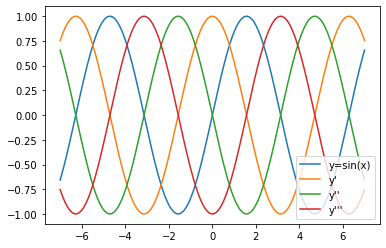

In [5]:
import matplotlib.pyplot as plt

x = Variable(np.linspace(-7, 7, 200))
y = F.sin(x)
y.backward(create_graph=True)

logs = [y.data]

for i in range(3):
    logs.append(x.grad.data)
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i, v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc='lower right')
plt.show()


### Step 35 고차 미분 계산 그래프

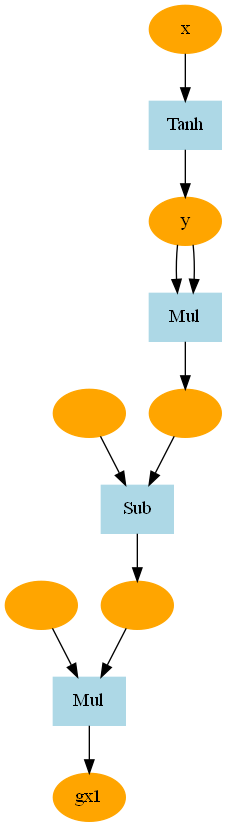

In [2]:
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph
import dezero.functions as F

x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
y.backward(create_graph=True)

iters = 0

for i in range(iters):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

gx = x.grad
gx.name = 'gx' + str(iters+1)
plot_dot_graph(gx, verbose=False, to_file='tanh.png')

### Step 36 고차 미분 이외의 용도
미분의 식을 구하고, 그 식을 사용하여 계산한 후, 또다시 미분하는 문제를 double backprop으로 해결할 수 있다.

In [3]:
import numpy as np
from dezero import Variable

x = Variable(np.array(2.0))
y = x ** 2
y.backward(create_graph=True)
gx = x.grad
x.cleargrad()

z = gx ** 3 + y
z.backward()
print(x.grad )

variable(100.0)
